This example demonstrates the use of the cross-validation and the generalized matrix Rayleigh quotient (GMRQ) for selecting
MSM hyperparameters. The GMRQ is a criterion which "scores" how well the MSM eigenvectors generated on the training dataset
serve as slow coordinates for the test dataset [1].

[1] McGibbon, R. T. and V. S. Pande, [Variational cross-validation of slow dynamical modes in molecular kinetics](http://arxiv.org/abs/1407.8083) (2014)

In [4]:
from msmbuilder.msm import MarkovStateModel
from msmbuilder.featurizer import DihedralFeaturizer
from msmbuilder.decomposition import tICA
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats.distributions import randint
from msmbuilder.cluster import MiniBatchKMeans
import matplotlib.pyplot as pp
import numpy as np
from mdtraj.utils import timing
import mdtraj as md
%matplotlib inline

Load trajectories using dataset function.

In [5]:
from msmbuilder.dataset import dataset
with timing("Loading trajectories as a dataset object..."):
    xyz = dataset("/Users/je714/wt_data/run1/05*nc", topology="/Users/je714/wt_data/test.pdb")
print("Loaded %d files\n" % len(xyz))

Loading trajectories as a dataset object...: 0.190 seconds
Loaded 4 files



Load the same trajectories using the `load_Trajs` function, which returns the trajectory objects in a list.

In [6]:
def load_Trajs(trajfiles_list, prmtop_file, stride=1, chunk=100):
    """
    Iteratively loads a list of NetCDF files and returns them
    as a list of mdtraj.Trajectory objects

    Parameters
    ----------
    trajfiles_list: list of str
            List with the names of trajectory files
    prmtop_file:  str
            Name of the prmtop file
    stride: int
            Frames to be used when loading the trajectories
    chunk:  int
            Number of frames to load at once from disk per iteration.
            If 0, load all.

    Returns
    -------
    list_chunks: list
            List of mdtraj.Trajectory objects, each of 'chunk' lenght
    """
    list_chunks = []
    for traj in trajfiles_list:
        for frag in md.iterload(traj, chunk=chunk, top=prmtop_file,
                                stride=stride):
            list_chunks.append(frag)
    return(list_chunks)

from glob import glob
tj_list = sorted(glob("/Users/je714/wt_data/run1/05*nc"))
tp = "/Users/je714/wt_data/test.pdb"
with timing("Loading trajectories in a list with md.iterload..."):
    my_trajs = load_Trajs(tj_list, tp, chunk = 1000)

Loading trajectories in a list with md.iterload...: 3.103 seconds


Now load the example alanine dipeptide trajectories to test the functions in this notebook.

In [7]:
from msmbuilder.example_datasets import fetch_alanine_dipeptide
with timing("Loading alanine dipeptide test trajectories..."):
    ala_trajs = fetch_alanine_dipeptide()["trajectories"]

Loading alanine dipeptide test trajectories...: 0.147 seconds


Both `my_trajs` and `ala_trajs` are lists of `mdtraj.core.trajectory.Trajectory` objects.

In [9]:
print(type(ala_trajs) == type(my_trajs))
print(type(ala_trajs[0]))
print(type(my_trajs[0]))


True
<class 'mdtraj.core.trajectory.Trajectory'>
<class 'mdtraj.core.trajectory.Trajectory'>


Do cross validation on the hyperparameters of the model:
- the tICA lag time (set to retain 4 tICs)
- the number of clusters (using MiniBatchKMeans algorithm)
- the MSM lag time (set to calculate 3 dynamical timescales, and using a maximum likelihood method to enforce the reversibility of the transition matrix).


We first featurize the trajectory on the phi/psi dihedral angles.

In [10]:
model = Pipeline([
    ('featurizer', DihedralFeaturizer(types=['phi', 'psi'])),
    ('tica', tICA(n_components=4)),
    ('clusterer', MiniBatchKMeans()),
    ('msm', MarkovStateModel(n_timescales=3, ergodic_cutoff='on', reversible_type='mle', verbose=False))
])
search = RandomizedSearchCV(model, n_iter=50, cv=3, refit=False, param_distributions={
        'tica__lag_time':randint(1,200),    
        'clusterer__n_clusters':randint(1,200),
        'msm__lag_time':randint(1,200)
})

Test the cross-validation on the alanine dataset. Doesn't give any errors.

In [11]:
with timing('Cross-validation on alanine...'):
    ala_scores = search.fit(ala_trajs)

Cross-validation on alanine...: 110.123 seconds


Let's visualize the scores for the three hyperparameters for the alanine dipeptide.

In [12]:
def plot_scores(score_matrix):
    scores = np.array([[np.mean(e.cv_validation_scores),
                        np.std(e.cv_validation_scores),
                        e.parameters['tica__lag_time'],
                        e.parameters['clusterer__n_clusters'],
                        e.parameters['msm__lag_time']]
                        for e in score_matrix.grid_scores_])

    mean_score_value = scores[:,0]
    std_score_value = scores[:,1]
    lags_tica = scores[:,2]
    cluster_number = scores[:,3]
    lags_msm = scores[:,4]

    pp.figure(figsize=(14,4))
    pp.grid(False)
    interval = 2*std_score_value
    # subplot1
    pp.subplot(1,3,1, axisbg='white')
    pp.errorbar(x=lags_tica, y=mean_score_value, yerr=interval, color = 'b', fmt='o')
    pp.plot(pp.xlim(), [search.best_score_]*2, 'k-.', label = 'best')
    pp.xlabel("tICA lag time (ns)")
    pp.ylabel("Score")
    # subplot2
    pp.subplot(1,3,2, axisbg='white')
    pp.errorbar(x=cluster_number, y=mean_score_value, yerr=interval,  color = 'r', fmt='o')
    pp.plot(pp.xlim(), [search.best_score_]*2, 'k-.', label = 'best')
    pp.xlabel("Number of clusters")
    pp.ylabel("Score")
    # subplot3
    pp.subplot(1,3,3, axisbg='white')
    pp.errorbar(x=lags_msm, y=mean_score_value, yerr=interval, color = 'g', fmt='o')
    pp.plot(pp.xlim(), [search.best_score_]*2, 'k-.', label = 'best')
    pp.xlabel("MSM lag time")
    pp.ylabel("Score")

    pp.tight_layout()

Best hyperparameters combination:
clusterer__n_clusters	20
tica__lag_time	52
msm__lag_time	11
Score = 2.14


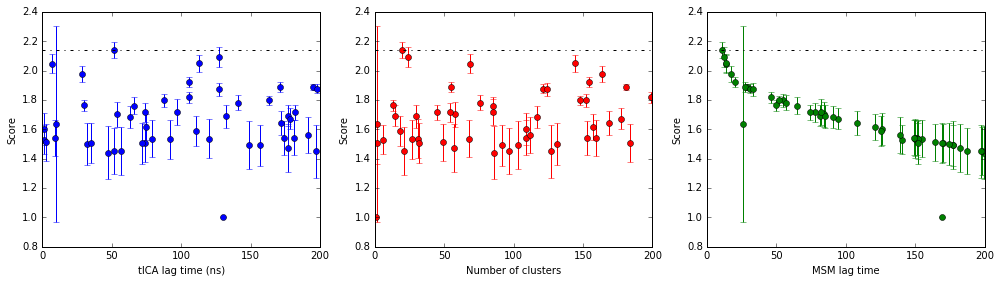

In [13]:
print("Best hyperparameters combination:")
for key, value in ala_scores.best_params_.items():
    print("%s\t%s" % (key, value))
print("Score = %.2f" % ala_scores.best_score_)
plot_scores(ala_scores)

Analyzing my trajectories stored in a list (`my_trajs`), same as `ala_trajs` in principle.

In [17]:
with timing("Cross-validation on my_trajs..."):
    my_scores = search.fit(my_trajs)

Cross-validation on my_trajs...: 3.875 seconds


ValueError: not enough values to unpack (expected 2, got 0)

Let's try applying the pipelin on the `dataset` object. As seen in the [introductory](https://github.com/msmbuilder/msmbuilder/blob/master/examples/Intro.ipynb) notebook, one can directly apply to a `dataset` object the `DihedralFeaturizer`.

Nevertheless, if used in the pipeline it crashes.

In [19]:
with timing('Cross-validation on the xyz dataset'):
    my_scores = search.fit(xyz)

Cross-validation on the xyz dataset: 23.093 seconds


ValueError: not enough values to unpack (expected 2, got 0)